In [3]:
#download required dependencies 
!pip install geopandas
!pip install netCDF4
!pip install minisom

     |████████████████████████████████| 901kB 2.8MB/s 
     |████████████████████████████████| 17.9MB 50.1MB/s 
     |████████████████████████████████| 9.8MB 37.4MB/s 
  Created wheel for munch: filename=munch-2.3.2-py2.py3-none-any.whl size=6614 sha256=5c79d3fa92168bc1de0c8a81c1aa59c25f13414913a855f1336269feeb6415f8
  Stored in directory: /root/.cache/pip/wheels/db/bf/bc/06a3e1bfe0ab27d2e720ceb3cff3159398d92644c0cec2c125
Successfully built munch
     |████████████████████████████████| 4.1MB 2.8MB/s 
     |████████████████████████████████| 307kB 41.5MB/s 
  Created wheel for minisom: filename=MiniSom-2.1.9-cp36-none-any.whl size=6675 sha256=151463caccb72918e0440b3f0c852a7fc56ccf791a359224d420524937927784
  Stored in directory: /root/.cache/pip/wheels/f9/70/2e/5fe380eaea27f5de4843c767908d5221b0f9a12247cfb62de1
Successfully built minisom


In [2]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#load in functions required and dependencies to use them
%run all_functions.ipynb

In [0]:
#load data

colabDataPath = '/content/drive/My Drive/Colab Notebooks/T_P_F_pca_lstm/'

pickle_in = open(colabDataPath + 'flowDict.pickle','rb')
flowDict = pickle.load(pickle_in)

pickle_in = open(colabDataPath + 'tempDict_AB.pickle','rb')
tempDict = pickle.load(pickle_in)

pickle_in = open(colabDataPath + 'precDict_AB.pickle','rb')
precDict = pickle.load(pickle_in)

pickle_in = open(colabDataPath + 'relHDict_AB.pickle','rb')
relHDict = pickle.load(pickle_in)

pickle_in = open(colabDataPath + 'ssrdDict_AB.pickle','rb')
ssrdDict = pickle.load(pickle_in)

In [0]:
#unpack data

stationLat = flowDict['stationLat']
stationLon = flowDict['stationLon']
eraLat = tempDict['latERA']
eraLon = tempDict['lonERA']

flowDays = flowDict['windowDays']
flowMonths = flowDict['windowMonths']
flowYears = flowDict['windowYears']
eraDays = tempDict['daysERA']
eraMonths = tempDict['monthsERA']
eraYears = tempDict['yearsERA']

F = flowDict['all_flowwindow_norm_NF'] #normalized discharge with nans filled (NF)
T = tempDict['T']
P = precDict['P']
H = relHDict['H']
S = ssrdDict['S']

In [0]:
#set nan values to mean values of field (ie: out of province values

meanT = np.nanmean(T)
meanP = np.nanmean(P)
meanH = np.nanmean(H)
meanS = np.nanmean(S)

Tall = np.copy(T)
Tall[np.where(np.isnan(Tall))] = np.nanmean(T)
T = Tall

Pall = np.copy(P)
Pall[np.where(np.isnan(Pall))] = np.nanmean(P)
P = Pall

Hall = np.copy(H)
Hall[np.where(np.isnan(Hall))] = np.nanmean(H)
H = Hall

Sall = np.copy(S)
Sall[np.where(np.isnan(Sall))] = np.nanmean(S)
S = Sall

In [0]:
#make data have same time range
startYear = max(int(np.min(eraYears)),int(np.min(flowYears)))

indStartERA = min(np.argwhere(eraYears==startYear))[0]
indStartFlow = min(np.argwhere(flowYears==startYear))[0]

F = np.asarray(np.transpose(np.squeeze(F[indStartFlow:])))
T = np.asarray(T[indStartERA:])
P = np.asarray(P[indStartERA:])
H = np.asarray(H[indStartERA:])
S = np.asarray(S[indStartERA:])

#just alberta
T = T[:,:15,29:]
P = P[:,:15,29:]
H = H[:,:15,28:]
S = S[:,:15,28:]

flowDays = flowDays[indStartFlow:]
flowMonths = flowMonths[indStartFlow:]
flowYears = flowYears[indStartFlow:]

eraDays = eraDays[indStartERA:]
eraMonths = eraMonths[indStartERA:]
eraYears = eraYears[indStartERA:]

seasonClass = get_SeasonClass(days=eraDays, months=eraMonths, years=eraYears)

In [237]:
print(np.shape(F),np.shape(T),np.shape(P),np.shape(H),np.shape(S))

(8766, 194) (8766, 15, 14) (8766, 15, 14) (8766, 15, 14) (8766, 15, 14)


In [0]:
#prep data: filter out some of the noise in streamflow

Fsmooth = np.empty(np.shape(F))
window = 10
for stream in range(np.shape(F)[1]):
  
  f = pd.Series(F[:,stream])
  fsmooth = f.rolling(window).mean()
  Fsmooth[:,stream] = fsmooth
  Fsmooth[:window-1,stream] = Fsmooth[window,stream]
  Fsmooth[-window+1:,stream] = Fsmooth[-window,stream]
  


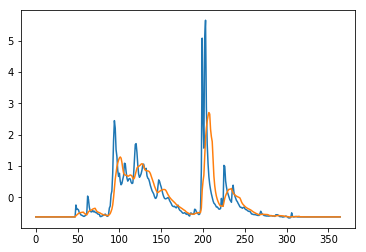

In [239]:
plt.plot(F[:365,0])
plt.plot(Fsmooth[:365,0])

In [0]:
F = Fsmooth

In [0]:
#prep data: standardize

#indices of testing/training
trainStartYear = 1987
trainFinYear = 2000
testStartYear = 2001
testFinYear = 2010

trainInds = np.squeeze(np.argwhere((flowYears>=trainStartYear) & (flowYears<=trainFinYear)))
testInds = np.squeeze(np.argwhere((flowYears>=testStartYear) & (flowYears<=testFinYear)))

#standardize variables individually (normalize wrt training period), then save as 32-bit rather than 64-bit for space
Tmean_train = np.mean([T[trainInds[ii]] for ii in range(len(trainInds))])
Tstd_train = np.std([T[trainInds[ii]] for ii in range(len(trainInds))])
Tnorm = (T - Tmean_train)/Tstd_train
Tnorm = np.single(Tnorm)

Pmean_train = np.mean([P[trainInds[ii]] for ii in range(len(trainInds))])
Pstd_train = np.std([P[trainInds[ii]] for ii in range(len(trainInds))])
Pnorm = (P - Pmean_train)/Pstd_train
Pnorm = np.single(Pnorm)

Hmean_train = np.mean([H[trainInds[ii]] for ii in range(len(trainInds))])
Hstd_train = np.std([H[trainInds[ii]] for ii in range(len(trainInds))])
Hnorm = (H - Hmean_train)/Hstd_train
Hnorm = np.single(Hnorm)

Smean_train = np.mean([S[trainInds[ii]] for ii in range(len(trainInds))])
Sstd_train = np.std([S[trainInds[ii]] for ii in range(len(trainInds))])
Snorm = (S - Smean_train)/Sstd_train
Snorm = np.single(Snorm)

#Fmean_train = np.nanmean([F[ii][trainInds[366:]] for ii in range(len(F))])
#Fstd_train = np.nanstd([F[ii][trainInds[366:]] for ii in range(len(F))])
Fmean_train = np.mean(F[trainInds[366:],:])
Fstd_train = np.std(F[trainInds[366:],:])
Fnorm = (F - Fmean_train)/Fstd_train
Fnorm = np.single(Fnorm)

In [0]:
#construct train and test predictor/target tensors

#transfer: season
y_season_train = seasonClass[366:len(trainInds)+366,:]
y_season_test = seasonClass[testInds[1:],:]

#target data
y_train = np.squeeze([Fnorm[366:len(trainInds)+366,ii] for ii in range(np.shape(F)[1])])
y_test = np.squeeze([Fnorm[testInds[1:],ii] for ii in range(np.shape(F)[1])])

#first, make (n_time x n_lon x n_lat x n_vars) tensor 
#x_intermediate = np.zeros((8766,17,43,2))
x_intermediate = np.empty((8766,15,14,4),dtype='single')
x_intermediate[:,:,:,0] = Tnorm
x_intermediate[:,:,:,1] = Pnorm
x_intermediate[:,:,:,2] = Hnorm
x_intermediate[:,:,:,3] = Snorm
x_train_intermediate = x_intermediate[trainInds]
x_test_intermediate = x_intermediate[testInds]

In [0]:
#now, convert x_intermediate into (n_time x 365 x n_lon x n_lat x n_vars) tensor
x = np.empty((8766-365,365,15,14,4),dtype='single')
x_train = np.empty((len(trainInds),365,15,14,4),dtype='single')
x_test = np.empty((len(testInds)-1,365,15,14,4),dtype='single')

In [0]:
for ii in range(1000):
    x_train[ii] = x_intermediate[ii:ii+365]

In [0]:
for ii in range(1000,2000):
    x_train[ii] = x_intermediate[ii:ii+365]

In [0]:
for ii in range(2000,3000):
    x_train[ii] = x_intermediate[ii:ii+365]

In [0]:
for ii in range(3000,4000):
    x_train[ii] = x_intermediate[ii:ii+365]

In [0]:
for ii in range(4000,len(trainInds)):
    x_train[ii] = x_intermediate[ii:ii+365]

In [0]:
for ii in range(1000):
    x_test[ii] = x_intermediate[ii+len(trainInds)-365:ii+len(trainInds)]

In [0]:
for ii in range(1000,2000):
    x_test[ii] = x_intermediate[ii+len(trainInds)-365:ii+len(trainInds)]

In [0]:
for ii in range(2000,len(testInds)-1):
    x_test[ii] = x_intermediate[ii+len(trainInds)-365:ii+len(trainInds)]

In [0]:
saveTrainVars=0
if saveTrainVars:
    np.savez("T_P_H_train_1987_2000_era_interim", x_train)
    #np.savez_compressed("T_P_train_1987_2000_era_interim_compressed", x_train)
    
saveTestVars=0
if saveTestVars:
    np.savez("T_P_H_test_1987_2000_era_interim", x_test)
    #np.savez_compressed("T_P_test_1987_2000_era_interim_compressed", x_test)

In [253]:
import keras
from keras import Model, Sequential, regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv3D, Conv2D, MaxPooling3D, MaxPooling2D, Flatten, TimeDistributed, LSTM, Dense, Dropout

#CNN model
print('Building model...')

model = Sequential()

model.add(TimeDistributed(
    Conv2D(filters = 8, kernel_size = (2,2), activation='relu',data_format='channels_last', padding='same'), 
    input_shape=(365,15,14,4)))

model.add(TimeDistributed(
    Conv2D(filters = 8, kernel_size = (2,2), activation='relu',data_format='channels_last', padding='same'), 
    input_shape=(365,15,14,4)))

model.add(TimeDistributed(MaxPooling2D(pool_size = 2)))

#model.add(TimeDistributed(
#    Conv2D(filters = 32, kernel_size = (2,2), activation='relu',data_format='channels_last', padding='same'), 
#    ))

#model.add(TimeDistributed(
#    Conv2D(filters = 32, kernel_size = (2,2), activation='relu',data_format='channels_last', padding='same'), 
#    ))

#model.add(TimeDistributed(MaxPooling2D(pool_size = 2)))

#model.add(TimeDistributed(
#    Conv2D(filters = 64, kernel_size = (2,2), activation='relu',data_format='channels_last', padding='same'), 
#    ))

#model.add(TimeDistributed(
#    Conv2D(filters = 64, kernel_size = (2,2), activation='relu',data_format='channels_last', padding='same'), 
#    ))
#model.add(TimeDistributed(MaxPooling2D(pool_size = 2)))

model.add(TimeDistributed(Flatten()))

#LSTM model with time-distributed CNN as input
#model.add(LSTM(units = 40, activation='tanh', recurrent_activation='hard_sigmoid', 
#               use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', 
#               bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None, 
#               recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, 
#               kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, implementation=1, 
#               return_sequences=True, return_state=False))
#model.add(LSTM(units = 40, activation='tanh', recurrent_activation='hard_sigmoid', 
#               use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', 
#               bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None, 
#               recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, 
#               kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, implementation=1, 
#               return_sequences=False, return_state=False))
#model.add(Dense(194, activation = 'relu'))

model.add(LSTM(40, return_sequences=True))
model.add(Dropout(rate=0.4))
#model.add(LSTM(40, return_sequences=True))
#model.add(Dropout(rate=0.2))
#model.add(LSTM(40, return_sequences=True))
#model.add(Dropout(rate=0.2))
model.add(Flatten())
model.add(Dense(4, activation = 'softmax'))

model.summary()

Building model...
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_27 (TimeDis (None, 365, 15, 14, 8)    136       
_________________________________________________________________
time_distributed_28 (TimeDis (None, 365, 15, 14, 8)    264       
_________________________________________________________________
time_distributed_29 (TimeDis (None, 365, 7, 7, 8)      0         
_________________________________________________________________
time_distributed_30 (TimeDis (None, 365, 392)          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 365, 40)           69280     
_________________________________________________________________
dropout_7 (Dropout)          (None, 365, 40)           0         
_________________________________________________________________
flatten_12 (Flatten)         (None,

In [254]:
#compile
print('Compiling model...')
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=0.0005),
              metrics=['acc'])

Compiling model...


In [255]:
#fit
batch_size = 64
epochs = 3
history = model.fit(x_train, y_season_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_season_test))

Train on 5114 samples, validate on 3651 samples
Epoch 1/3
5114/5114 [==============================] - 95s 19ms/step - loss: 0.1203 - acc: 0.9511 - val_loss: 0.0550 - val_acc: 0.9745
Epoch 2/3
5114/5114 [==============================] - 85s 17ms/step - loss: 0.0517 - acc: 0.9763 - val_loss: 0.0479 - val_acc: 0.9792
Epoch 3/3
5114/5114 [==============================] - 85s 17ms/step - loss: 0.0340 - acc: 0.9855 - val_loss: 0.0468 - val_acc: 0.9795


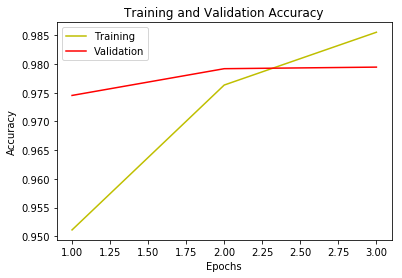

In [256]:
#visualize transfer task accuracy

acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'y', label='Training')
plt.plot(epochs, val_acc, 'r', label='Validation')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [27]:
print('Calculating predicted training values...')
y_season_train_pred = model.predict(x_train)

print('Calculating predicted testing values...')
y_season_test_pred = model.predict(x_test)

Calculating predicted training values...
Calculating predicted testing values...


In [0]:
type(x_test[0,0,0,0,0])

numpy.float32

In [0]:
#make confusion matrix
from keras.metrics import confusion_matrix
matrix = confusion_matrix(y_season_test.argmax(axis=1), y_season_test_pred.argmax(axis=1))

ImportError: ignored

In [0]:
#save model
savePath = colabDataPath = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/'
model.save(savePath+'model_transfer_season_test.h5')

In [0]:
#load model
model_load = keras.models.load_model(savePath+'model_transfer_season_test.h5')

In [259]:
model_load.pop()
#model_load.add(Dense(194, activation = 'relu',kernel_regularizer=regularizers.l2(0.01)))
#model_load.add(Dropout(rate=0.5))
model_load.add(Dense(1, activation = 'linear',kernel_regularizer=regularizers.l2(0.01)))
model_load.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_27 (TimeDis (None, 365, 15, 14, 8)    136       
_________________________________________________________________
time_distributed_28 (TimeDis (None, 365, 15, 14, 8)    264       
_________________________________________________________________
time_distributed_29 (TimeDis (None, 365, 7, 7, 8)      0         
_________________________________________________________________
time_distributed_30 (TimeDis (None, 365, 392)          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 365, 40)           69280     
_________________________________________________________________
dropout_7 (Dropout)          (None, 365, 40)           0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 14600)           

In [260]:
#compile
print('Compiling model...')
model_load.compile(loss=keras.losses.MSE,
              optimizer=keras.optimizers.Adam(lr=0.001),
              metrics=['mae'])

Compiling model...


In [215]:
np.shape(y_train)

(194, 5114)

In [261]:
#fit
batch_size = 64
epochs = 10
history = model_load.fit(x_train, y_train[104,:].T,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test[104,:].T))

Train on 5114 samples, validate on 3651 samples
Epoch 1/10
5114/5114 [==============================] - 93s 18ms/step - loss: 0.3819 - mean_absolute_error: 0.3749 - val_loss: 0.1346 - val_mean_absolute_error: 0.2232
Epoch 2/10
5114/5114 [==============================] - 84s 16ms/step - loss: 0.1772 - mean_absolute_error: 0.2465 - val_loss: 0.1984 - val_mean_absolute_error: 0.2882
Epoch 3/10
5114/5114 [==============================] - 84s 16ms/step - loss: 0.1310 - mean_absolute_error: 0.2203 - val_loss: 0.1812 - val_mean_absolute_error: 0.2835
Epoch 4/10
5114/5114 [==============================] - 84s 16ms/step - loss: 0.0834 - mean_absolute_error: 0.1789 - val_loss: 0.1641 - val_mean_absolute_error: 0.2627
Epoch 5/10
5114/5114 [==============================] - 84s 16ms/step - loss: 0.0611 - mean_absolute_error: 0.1488 - val_loss: 0.1950 - val_mean_absolute_error: 0.3069
Epoch 6/10
5114/5114 [==============================] - 84s 16ms/step - loss: 0.0487 - mean_absolute_error: 0.13

In [0]:
savePath = colabDataPath = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/'
model_load.save(savePath+'model_initial_test.h5')

In [0]:
model_load2 = keras.models.load_model(savePath+'model_initial_test.h5')

In [265]:
model_load2.pop()
model_load2.add(Dense(194, activation = 'linear',kernel_regularizer=regularizers.l2(0.01)))
#model_load.add(Dropout(rate=0.5))
#model_load.add(Dense(1, activation = 'linear',kernel_regularizer=regularizers.l2(0.01)))
model_load2.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_27 (TimeDis (None, 365, 15, 14, 8)    136       
_________________________________________________________________
time_distributed_28 (TimeDis (None, 365, 15, 14, 8)    264       
_________________________________________________________________
time_distributed_29 (TimeDis (None, 365, 7, 7, 8)      0         
_________________________________________________________________
time_distributed_30 (TimeDis (None, 365, 392)          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 365, 40)           69280     
_________________________________________________________________
dropout_7 (Dropout)          (None, 365, 40)           0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 14600)           

In [266]:
#compile
print('Compiling model...')
model_load2.compile(loss=keras.losses.MSE,
              optimizer=keras.optimizers.Adam(lr=0.001),
              metrics=['mae'])

Compiling model...


In [267]:
#fit
batch_size = 64
epochs = 10
history = model_load2.fit(x_train, y_train.T,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test.T))

Train on 5114 samples, validate on 3651 samples
Epoch 1/10
5114/5114 [==============================] - 96s 19ms/step - loss: 1.0330 - mean_absolute_error: 0.4305 - val_loss: 0.8461 - val_mean_absolute_error: 0.4767
Epoch 2/10
5114/5114 [==============================] - 85s 17ms/step - loss: 0.5439 - mean_absolute_error: 0.3796 - val_loss: 0.8228 - val_mean_absolute_error: 0.4616
Epoch 3/10
5114/5114 [==============================] - 85s 17ms/step - loss: 0.5182 - mean_absolute_error: 0.3747 - val_loss: 0.8246 - val_mean_absolute_error: 0.4619
Epoch 4/10
5114/5114 [==============================] - 85s 17ms/step - loss: 0.4971 - mean_absolute_error: 0.3708 - val_loss: 0.8468 - val_mean_absolute_error: 0.4782
Epoch 5/10
5114/5114 [==============================] - 85s 17ms/step - loss: 0.4835 - mean_absolute_error: 0.3676 - val_loss: 0.8213 - val_mean_absolute_error: 0.4635
Epoch 6/10
5114/5114 [==============================] - 84s 16ms/step - loss: 0.4733 - mean_absolute_error: 0.36

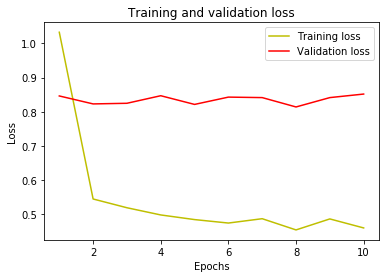

In [271]:
#visualize training loss

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [272]:
#make predictions with model

print('Calculating predicted training values...')
y_train_predicted = model_load2.predict(x_train)

print('Calculating predicted testing values...')
y_test_predicted = model_load2.predict(x_test)
y_test_predicted = y_test_predicted.T

Calculating predicted training values...
Calculating predicted testing values...


In [0]:
n_target = 100
plt.figure(figsize=(4,n_target*4))

for pred in range(n_target):

    plt.subplot(n_target,1,pred+1)
    plt.scatter(y_test_predicted[:,pred],y_test.T[:,pred])
    plt.ylim((-1,2))

In [0]:
#check r2 at each station

from sklearn.metrics import r2_score

r2 = np.empty(194)
for kk in range(np.shape(y_test)[0]):
  r2[kk] = r2_score(y_test[kk,:],y_test_predicted[kk,:])

In [0]:
r2[np.where(r2<0)]=0

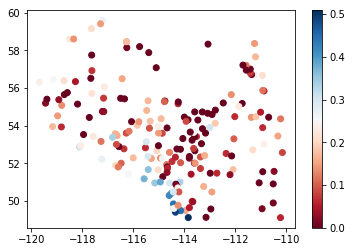

In [275]:
#visualize

plt.scatter(stationLon,stationLat,c=r2,cmap='RdBu')
plt.colorbar()

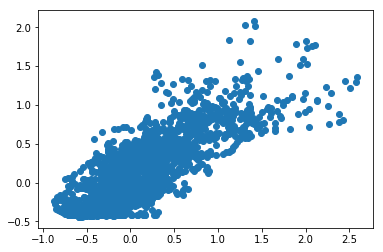

In [230]:
plt.scatter(np.squeeze(y_test_predicted),np.squeeze(y_test[106,:]))


In [0]:
np.savez(savePath+"y_test_predicted", y_test_predicted)
np.savez(savePath+"y_train_predicted", y_train_predicted)

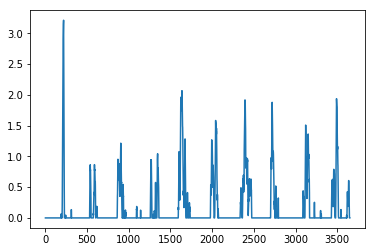

In [276]:
#SOM on seasonal hydrographs to see what our results are
#a = np.load('y_test_predicted.npz')
#y_test_predicted = a['arr_0']
#y_test_predicted = y_test_predicted.T

y_new = np.empty((np.shape(y_test_predicted)[0],np.shape(y_test_predicted)[1]+1),dtype='single')
y_new[:,1:] = y_test_predicted
y_new[:,0] = y_new[:,1]

y_new[:,1:] = y_test_predicted
y_new[:,0] = y_new[:,1]

plt.plot(y_new[107,:])

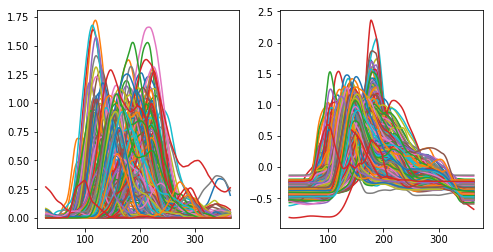

In [277]:
#compute smoothed seasonal over test period
#plan: find leap years, remove last day of SF from leap years, reshape SF at each station into matrix, find average

windowYears = flowDict['windowYears']
trainYears = windowYears[trainInds]
testYears = windowYears[testInds]

#the first value in y_test is the second day in testInds
y_newP = np.empty((np.shape(y_test_predicted)[0],np.shape(y_test_predicted)[1]+1),dtype='single')
y_newP[:,1:] = y_test_predicted
y_newP[:,0] = y_newP[:,1]

y_new = np.empty((np.shape(y_test)[0],np.shape(y_test)[1]+1),dtype='single')
y_new[:,1:] = y_test
y_new[:,0] = y_new[:,1]

#remove last day of leap years, so we can reshape into 365-row matrix
lastDayOfYear = np.argwhere(testYears[1:] - testYears[:-1] == 1) + 1
lastDayOfLeapYear = lastDayOfYear[np.argwhere(lastDayOfYear[1:]-lastDayOfYear[:-1] ==366)[:,0]+1]

y_newP1 = np.copy(y_newP)
y_newP2 = np.delete(y_newP1,lastDayOfLeapYear,axis=1)

y_new1 = np.copy(y_new)
y_new2 = np.delete(y_new1,lastDayOfLeapYear,axis=1)

y_test_predicted_seasonal = np.empty((len(y_newP2),365),dtype='single')
y_test_predicted_seasonal_smooth = np.empty_like(y_test_predicted_seasonal)

y_test_seasonal = np.empty((len(y_new2),365),dtype='single')
y_test_seasonal_smooth = np.empty_like(y_test_seasonal)

for streamGauge in range(len(y_new2)):
    
    dummy = np.reshape(y_newP2[streamGauge,:],(10,365))
    y_test_predicted_seasonal[streamGauge,:] = np.mean(dummy,axis=0)
    
    x = pd.Series(y_test_predicted_seasonal[streamGauge,:])      
    y_test_predicted_seasonal_smooth[streamGauge] = x.rolling(30).mean()
    
    dummy = np.reshape(y_new2[streamGauge,:],(10,365))
    y_test_seasonal[streamGauge,:] = np.mean(dummy,axis=0)
    
    x = pd.Series(y_test_seasonal[streamGauge,:])      
    y_test_seasonal_smooth[streamGauge] = x.rolling(30).mean()

plt.figure(figsize=(8,4))
    
plt.subplot(121)
for ii in range(194):
    plt.plot(y_test_predicted_seasonal_smooth[ii,:])
    
plt.subplot(122)
for ii in range(194):
    plt.plot(y_test_seasonal_smooth[ii,:])

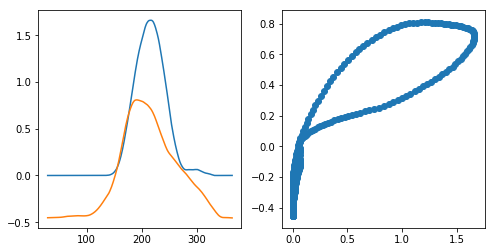

In [279]:
ind = 106

plt.figure(figsize=(8,4))

plt.subplot(121)
plt.plot(y_test_predicted_seasonal_smooth[ind,:])
plt.plot(y_test_seasonal_smooth[ind,:])

plt.subplot(122)
plt.scatter(y_test_predicted_seasonal_smooth[ind,:], y_test_seasonal_smooth[ind,:])

plt.show()

In [202]:
#do SOM

from minisom import MiniSom   
data = y_test_predicted_seasonal_smooth[:,31:-30]
som = MiniSom(3, 2, 304, sigma=1, learning_rate=0.5) # initialization of 6x6 SOM
som.pca_weights_init(data)
som.train_random(data, 500) # trains the SOM with 100 iterations

qnt = som.quantization(data)

/usr/local/lib/python3.6/dist-packages/minisom.py:296: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + c2*pc[pc_order[1]]


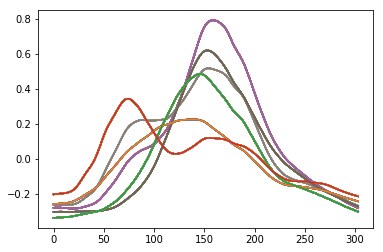

In [203]:
plt.plot(qnt.T)
plt.show()

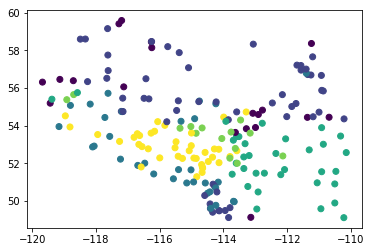

In [204]:
w = []
bmus = []
bmus_ref = [[1,4],[2,5],[3,6]]
for ii in range(194):
    w.append(som.winner(data[ii,:]))
    bmus.append(bmus_ref[w[ii][0]][w[ii][1]])

#plot_AB()
plt.scatter(stationLon,stationLat,c=bmus)